In [1]:
from datetime import datetime, timedelta
from collections import defaultdict

import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, make_pipeline

In [11]:
import xgboost as xgb

In [5]:
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("xgboost_tree_tuning")

2024/11/17 12:53:17 INFO mlflow.tracking.fluent: Experiment with name 'xgboost_tree_tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/lld-lead-scoring/analytics/mlruns/4', creation_time=1731847997784, experiment_id='4', last_update_time=1731847997784, lifecycle_stage='active', name='xgboost_tree_tuning', tags={}>

In [6]:
df_users = pd.read_csv('../data/random-users.csv')
df_logs = pd.read_csv('../data/random-logs.csv')

In [7]:
def preprocess_required_features(df):
    df = df.copy()
    
    def process_feature_string(feature_string):
        features = [f.strip() for f in feature_string.split(',')]
        return {f'required_feature_{feature}': 1 for feature in features}
    
    feature_dicts = df['required_features'].apply(process_feature_string)
    df = df.drop('required_features', axis=1)
    record_dicts = df.to_dict('records')
    
    for record, feature_dict in zip(record_dicts, feature_dicts):
        record.update(feature_dict)
    
    return record_dicts

In [8]:
def create_log_features(df_users, df_logs, cutoff_date):
    df_logs_filtered = df_logs[df_logs['timestamp'] < cutoff_date].copy()
    
    engagement_metrics = df_logs_filtered.groupby('user_id').agg({
        'timestamp': ['count', 'nunique'],  # Total actions and unique days
        'duration_seconds': ['sum', 'mean', 'std']  # Time spent metrics
    }).round(2)
    
    engagement_metrics.columns = [
        'total_actions',
        'active_days',
        'total_duration',
        'avg_duration',
        'std_duration'
    ]
    
    # Action category distribution
    category_counts = df_logs_filtered.groupby(['user_id', 'action_category']).size().unstack(
        fill_value=0
    ).add_prefix('category_')
    
    # Action type distribution (top 10 most common)
    top_actions = df_logs_filtered['action_type'].value_counts().nlargest(10).index
    action_counts = df_logs_filtered[df_logs_filtered['action_type'].isin(top_actions)]\
        .groupby(['user_id', 'action_type']).size().unstack(fill_value=0).add_prefix('action_')
    
    # Time-based features
    df_logs_filtered['hour'] = df_logs_filtered['timestamp'].dt.hour
    time_metrics = df_logs_filtered.groupby('user_id').agg({
        'hour': lambda x: len(x[x.between(9, 17)]) / len(x)  # Fraction of activity during business hours
    }).round(2)
    time_metrics.columns = ['business_hours_ratio']
    
    # Activity patterns
    df_logs_filtered['days_since_signup'] = (
        df_logs_filtered['timestamp'] - 
        df_logs_filtered['user_id'].map(df_users.set_index('user_id')['signup_date'])
    ).dt.days
    
    recency_metrics = df_logs_filtered.groupby('user_id').agg({
        'days_since_signup': ['min', 'max']
    }).round(2)
    recency_metrics.columns = ['days_to_first_action', 'days_to_last_action']
    
    # Advanced engagement metrics
    df_logs_filtered['prev_timestamp'] = df_logs_filtered.groupby('user_id')['timestamp'].shift(1)
    df_logs_filtered['time_between_actions'] = (
        df_logs_filtered['timestamp'] - df_logs_filtered['prev_timestamp']
    ).dt.total_seconds() / 3600  # Convert to hours
    
    engagement_patterns = df_logs_filtered.groupby('user_id').agg({
        'time_between_actions': ['mean', 'std']
    }).round(2)
    engagement_patterns.columns = ['avg_hours_between_actions', 'std_hours_between_actions']
    
    # Feature importance indicators
    feature_exploration = df_logs_filtered[
        df_logs_filtered['action_type'] == 'view_features'
    ].groupby('user_id').size().to_frame('feature_views')
    
    # Combine all features
    log_features = pd.concat([
        engagement_metrics,
        category_counts,
        action_counts,
        time_metrics,
        recency_metrics,
        engagement_patterns,
        feature_exploration
    ], axis=1).reset_index()
    
    # Fill NaN values with 0 for new users or users with missing metrics
    log_features = log_features.fillna(0)
    
    return log_features


def prepare_lead_scoring_data(df_users, df_logs, train_end_date, val_end_date):
    df_users = df_users.copy()
    df_logs = df_logs.copy()
    
    df_users['signup_date'] = pd.to_datetime(df_users['signup_date'])
    df_logs['timestamp'] = pd.to_datetime(df_logs['timestamp'])
    
    train_end_date = pd.to_datetime(train_end_date)
    val_end_date = pd.to_datetime(val_end_date)
    
    train_mask = df_users['signup_date'] < train_end_date
    val_mask = (df_users['signup_date'] >= train_end_date) & (df_users['signup_date'] < val_end_date)
    test_mask = df_users['signup_date'] >= val_end_date
    
    df_train = df_users[train_mask].copy()
    df_val = df_users[val_mask].copy()
    df_test = df_users[test_mask].copy()
    
    train_features = create_log_features(df_users, df_logs, train_end_date)
    val_features = create_log_features(df_users, df_logs, val_end_date)
    test_features = create_log_features(df_users, df_logs, df_logs['timestamp'].max())

    df_train = df_train.merge(train_features, on='user_id', how='left')
    df_val = df_val.merge(val_features, on='user_id', how='left')
    df_test = df_test.merge(test_features, on='user_id', how='left')

    return df_train, df_val, df_test

In [9]:
df_train, df_val, df_test = prepare_lead_scoring_data(
    df_users,
    df_logs,
    train_end_date='2024-03-01',
    val_end_date='2024-03-15'
)

In [10]:
def prepare_features(df):
    df = df.copy()
    
    date_columns = ['signup_date', 'conversion_date']
    exclude_columns = ['user_id', 'converted'] + date_columns

    df = df.drop(columns=exclude_columns)
    df = df.fillna(0)
    feature_dict = preprocess_required_features(df)

    return feature_dict

train_dicts = prepare_features(df_train)
val_dicts = prepare_features(df_val)
test_dicts = prepare_features(df_test)

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

## Training a single XGBoost model

Using Scikit-Learn wrapper

In [103]:
pipeline = make_pipeline(
    DictVectorizer(),
    xgb.XGBClassifier(
        n_estimators=34,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=1,
        n_jobs=-1
    )
)

pipeline.fit(train_dicts, y_train)

y_pred = pipeline.predict_proba(val_dicts)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
val_auc

np.float64(0.6090384188318898)

## Multi-Step training 

With scikit-learn wrapper and warm start

In [52]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [70]:
model = xgb.XGBClassifier(
    n_estimators=0,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=1,
    n_jobs=-1
)

In [62]:
train_scores = []
val_scores = []
eval_steps = list(range(5, 101, 5))

for n_trees in eval_steps:
    model.set_params(n_estimators=n_trees)

    if n_trees > 5:
        # print(f'continuing training with {n_trees=}')
        # continue training on top of the previous model
        model.fit(X_train, y_train, xgb_model=model)
    else:
        # print(f'train from scratch with {n_trees=}')
        # train the first iteration
        model.fit(X_train, y_train)

    train_pred = model.predict_proba(X_train)[:, 1]
    val_pred = model.predict_proba(X_val)[:, 1]
    
    train_auc = roc_auc_score(y_train, train_pred)
    val_auc = roc_auc_score(y_val, val_pred)
    
    train_scores.append(train_auc)
    val_scores.append(val_auc)
    
    print(f"Trees: {n_trees:3d} | Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")


Trees:   5 | Train AUC: 0.8780 | Val AUC: 0.5512
Trees:  10 | Train AUC: 0.9515 | Val AUC: 0.5730
Trees:  15 | Train AUC: 0.9909 | Val AUC: 0.5743
Trees:  20 | Train AUC: 0.9996 | Val AUC: 0.5902
Trees:  25 | Train AUC: 1.0000 | Val AUC: 0.6214
Trees:  30 | Train AUC: 1.0000 | Val AUC: 0.6046
Trees:  35 | Train AUC: 1.0000 | Val AUC: 0.6084
Trees:  40 | Train AUC: 1.0000 | Val AUC: 0.6009
Trees:  45 | Train AUC: 1.0000 | Val AUC: 0.5963
Trees:  50 | Train AUC: 1.0000 | Val AUC: 0.6054
Trees:  55 | Train AUC: 1.0000 | Val AUC: 0.5998
Trees:  60 | Train AUC: 1.0000 | Val AUC: 0.6023
Trees:  65 | Train AUC: 1.0000 | Val AUC: 0.5973
Trees:  70 | Train AUC: 1.0000 | Val AUC: 0.5995
Trees:  75 | Train AUC: 1.0000 | Val AUC: 0.5969
Trees:  80 | Train AUC: 1.0000 | Val AUC: 0.5964
Trees:  85 | Train AUC: 1.0000 | Val AUC: 0.5944
Trees:  90 | Train AUC: 1.0000 | Val AUC: 0.5944
Trees:  95 | Train AUC: 1.0000 | Val AUC: 0.5933
Trees: 100 | Train AUC: 1.0000 | Val AUC: 0.5888


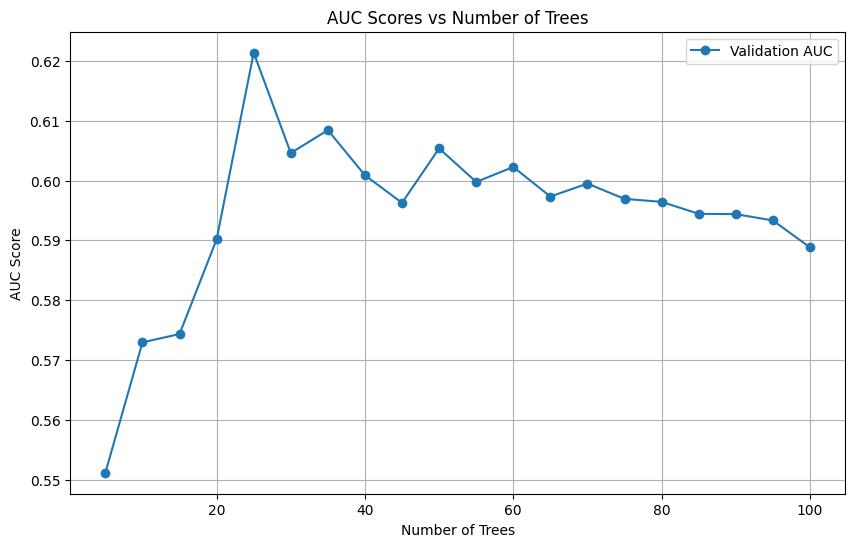

In [35]:
plt.figure(figsize=(10, 6))
# plt.plot(eval_steps, train_scores, label='Train AUC', marker='o')
plt.plot(eval_steps, val_scores, label='Validation AUC', marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('AUC Score')
plt.title('AUC Scores vs Number of Trees')
plt.grid(True)
plt.legend()
plt.show()

## Watchlist 

Using XGBoost API directly (with `DMatrix` and `xgboost.train`)

In [67]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [68]:
params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1
}

In [69]:
watchlist = [(dtrain, 'train'), (dval, 'eval')]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,  # we'll train up to 100 trees
    evals=watchlist,
    verbose_eval=5  # print evaluation every 5 rounds
)

[0]	train-auc:0.78441	eval-auc:0.51183
[5]	train-auc:0.89614	eval-auc:0.53406
[10]	train-auc:0.92652	eval-auc:0.55924
[15]	train-auc:0.95907	eval-auc:0.57689
[20]	train-auc:0.97575	eval-auc:0.56718
[25]	train-auc:0.98758	eval-auc:0.55441
[30]	train-auc:0.99353	eval-auc:0.54786
[35]	train-auc:0.99627	eval-auc:0.53870
[40]	train-auc:0.99818	eval-auc:0.54408
[45]	train-auc:0.99901	eval-auc:0.53831
[50]	train-auc:0.99950	eval-auc:0.54464
[55]	train-auc:0.99978	eval-auc:0.54819
[60]	train-auc:0.99977	eval-auc:0.54219
[65]	train-auc:0.99994	eval-auc:0.55102
[70]	train-auc:0.99995	eval-auc:0.54897
[75]	train-auc:0.99998	eval-auc:0.54564
[80]	train-auc:1.00000	eval-auc:0.54208
[85]	train-auc:1.00000	eval-auc:0.54003
[90]	train-auc:1.00000	eval-auc:0.53653
[95]	train-auc:1.00000	eval-auc:0.54075
[99]	train-auc:1.00000	eval-auc:0.53820


## Watchlist

Watchlist with the Scikit-Learn wrapper

In [91]:
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1,
    eval_metric='auc',  # Move eval_metric here
    n_jobs=-1
)

In [92]:
eval_set = [(X_train, y_train), (X_val, y_val)]

model.fit(
    X_train, 
    y_train,
    eval_set=eval_set,
    verbose=True,
)

[0]	validation_0-auc:0.66066	validation_1-auc:0.53642
[1]	validation_0-auc:0.68622	validation_1-auc:0.55205
[2]	validation_0-auc:0.69489	validation_1-auc:0.54031
[3]	validation_0-auc:0.70892	validation_1-auc:0.54464
[4]	validation_0-auc:0.71370	validation_1-auc:0.55421
[5]	validation_0-auc:0.71758	validation_1-auc:0.56290
[6]	validation_0-auc:0.71750	validation_1-auc:0.56307
[7]	validation_0-auc:0.72341	validation_1-auc:0.59008
[8]	validation_0-auc:0.72274	validation_1-auc:0.57495
[9]	validation_0-auc:0.72646	validation_1-auc:0.57167
[10]	validation_0-auc:0.73240	validation_1-auc:0.58178
[11]	validation_0-auc:0.73781	validation_1-auc:0.58955
[12]	validation_0-auc:0.74559	validation_1-auc:0.59419
[13]	validation_0-auc:0.74685	validation_1-auc:0.59852
[14]	validation_0-auc:0.74614	validation_1-auc:0.59610
[15]	validation_0-auc:0.74723	validation_1-auc:0.59358
[16]	validation_0-auc:0.74703	validation_1-auc:0.58714
[17]	validation_0-auc:0.74673	validation_1-auc:0.58547
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=1, ...)

In [93]:
# Get evaluation results
evals_result = model.evals_result()

In [104]:
validation_auc = evals_result['validation_1']['auc']
validation_auc = np.array(validation_auc)

best_auc = validation_auc.max()
best_num_trees = validation_auc.argmax() + 1
best_auc, best_num_trees

(np.float64(0.6090384188318898), np.int64(34))

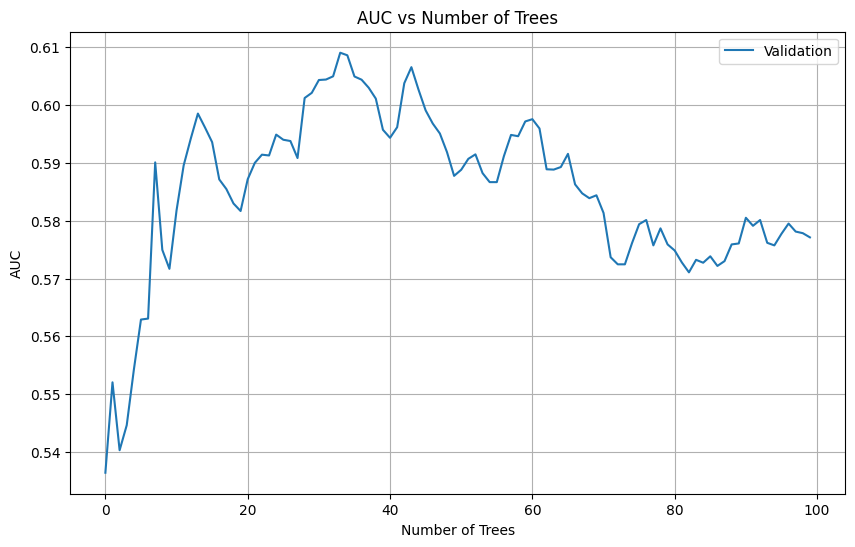

In [96]:
plt.figure(figsize=(10, 6))
# plt.plot(evals_result['validation_0']['auc'], label='Train')
plt.plot(validation_auc, label='Validation')
plt.xlabel('Number of Trees')
plt.ylabel('AUC')
plt.title('AUC vs Number of Trees')
plt.legend()
plt.grid()
plt.show()

## Random sampling parameter tuning

In [109]:
param_ranges = {
    'max_depth': range(3, 10),
    'min_child_weight': range(1, 6),
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
}

n_trials = 30
best_overall_auc = 0
best_overall_params = None
best_overall_trees = None

for trial in range(n_trials):
    with mlflow.start_run():
        # Sample random parameters
        params = {
            'max_depth': np.random.choice(param_ranges['max_depth']),
            'min_child_weight': np.random.choice(param_ranges['min_child_weight']),
            'learning_rate': np.random.choice(param_ranges['learning_rate']),
            'subsample': np.random.choice(param_ranges['subsample']),
            'colsample_bytree': np.random.choice(param_ranges['colsample_bytree']),
            'n_estimators': 200,
            'eval_metric': 'auc',
            'random_state': 1,
            'n_jobs': -1
        }
        
        # Create and train model
        model = xgb.XGBClassifier(**params)
        
        # Train with evaluation set
        model.fit(
            X_train, 
            y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=False
        )

        validation_auc = model.evals_result()['validation_1']['auc']
        validation_auc = np.array(validation_auc)
        best_auc = validation_auc.max()
        best_num_trees = validation_auc.argmax() + 1

        params_to_log = params.copy()
        params_to_log['n_estimators'] = best_num_trees
        mlflow.log_params(params_to_log)

        train_auc = model.evals_result()['validation_0']['auc'][best_num_trees - 1]
        
        mlflow.log_metrics({
            'best_val_auc': best_auc,
            'train_auc': train_auc
        })


        params['n_estimators'] = best_num_trees

        # Update best overall model if necessary
        if best_auc > best_overall_auc:
            best_overall_auc = best_auc
            best_overall_params = params.copy()
            best_overall_trees = best_num_trees
            
        print(f"\nTrial {trial + 1}/{n_trials}:")
        print(f"Params: {params}")
        print(f"Best num trees: {best_num_trees}")
        print(f"Best validation AUC: {best_auc:.4f}")
        print(f"Best overall AUC so far: {best_overall_auc:.4f}")

print("\nBest overall results:")
print(f"AUC: {best_overall_auc:.4f}")
print(f"Number of trees: {best_overall_trees}")
print("Parameters:")
for param, value in best_overall_params.items():
    print(f"  {param}: {value}")

2024/11/17 13:43:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run rogue-donkey-946 at: http://localhost:5000/#/experiments/4/runs/f0f7ff7ccd684dccae314f80f5a01c58.
2024/11/17 13:43:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 1/30:
Params: {'max_depth': np.int64(9), 'min_child_weight': np.int64(5), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(1.0), 'n_estimators': np.int64(77), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 77
Best validation AUC: 0.5740
Best overall AUC so far: 0.5740


2024/11/17 13:43:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run sassy-worm-525 at: http://localhost:5000/#/experiments/4/runs/4a0c1cb4968e46abbbd3e1ba4a478b41.
2024/11/17 13:43:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 2/30:
Params: {'max_depth': np.int64(8), 'min_child_weight': np.int64(1), 'learning_rate': np.float64(0.3), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.7), 'n_estimators': np.int64(103), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 103
Best validation AUC: 0.5934
Best overall AUC so far: 0.5934


2024/11/17 13:43:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run chill-midge-530 at: http://localhost:5000/#/experiments/4/runs/b52739810c604b9cbb628c5aceecec16.
2024/11/17 13:43:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 3/30:
Params: {'max_depth': np.int64(8), 'min_child_weight': np.int64(5), 'learning_rate': np.float64(0.3), 'subsample': np.float64(0.9), 'colsample_bytree': np.float64(1.0), 'n_estimators': np.int64(86), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 86
Best validation AUC: 0.5895
Best overall AUC so far: 0.5934


2024/11/17 13:43:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-mare-358 at: http://localhost:5000/#/experiments/4/runs/ee02379fc8cf42e2a1a24c96345d7d31.
2024/11/17 13:43:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 4/30:
Params: {'max_depth': np.int64(5), 'min_child_weight': np.int64(4), 'learning_rate': np.float64(0.3), 'subsample': np.float64(0.7), 'colsample_bytree': np.float64(0.9), 'n_estimators': np.int64(81), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 81
Best validation AUC: 0.6020
Best overall AUC so far: 0.6020


2024/11/17 13:43:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run placid-yak-449 at: http://localhost:5000/#/experiments/4/runs/b14be366554c432e887e59760fe88921.
2024/11/17 13:43:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 5/30:
Params: {'max_depth': np.int64(7), 'min_child_weight': np.int64(1), 'learning_rate': np.float64(0.3), 'subsample': np.float64(0.9), 'colsample_bytree': np.float64(0.8), 'n_estimators': np.int64(91), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 91
Best validation AUC: 0.5071
Best overall AUC so far: 0.6020


2024/11/17 13:43:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run thoughtful-toad-411 at: http://localhost:5000/#/experiments/4/runs/041236f124b04899a2942a24f012152b.
2024/11/17 13:43:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 6/30:
Params: {'max_depth': np.int64(5), 'min_child_weight': np.int64(4), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.9), 'colsample_bytree': np.float64(0.8), 'n_estimators': np.int64(11), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 11
Best validation AUC: 0.5819
Best overall AUC so far: 0.6020


2024/11/17 13:43:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-boar-954 at: http://localhost:5000/#/experiments/4/runs/1a6ef719d2e04210b50060cc6b273a33.
2024/11/17 13:43:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 7/30:
Params: {'max_depth': np.int64(4), 'min_child_weight': np.int64(3), 'learning_rate': np.float64(0.3), 'subsample': np.float64(0.9), 'colsample_bytree': np.float64(0.8), 'n_estimators': np.int64(32), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 32
Best validation AUC: 0.5782
Best overall AUC so far: 0.6020


2024/11/17 13:43:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run nosy-shark-690 at: http://localhost:5000/#/experiments/4/runs/ee9a189e87bc49e6b682f2cccbc6b778.
2024/11/17 13:43:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 8/30:
Params: {'max_depth': np.int64(8), 'min_child_weight': np.int64(2), 'learning_rate': np.float64(0.1), 'subsample': np.float64(0.9), 'colsample_bytree': np.float64(0.9), 'n_estimators': np.int64(23), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 23
Best validation AUC: 0.6321
Best overall AUC so far: 0.6321


2024/11/17 13:43:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run glamorous-steed-367 at: http://localhost:5000/#/experiments/4/runs/1522a822f739411ead5f4647bf3a59cd.
2024/11/17 13:43:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 9/30:
Params: {'max_depth': np.int64(8), 'min_child_weight': np.int64(4), 'learning_rate': np.float64(0.01), 'subsample': np.float64(1.0), 'colsample_bytree': np.float64(1.0), 'n_estimators': np.int64(200), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 200
Best validation AUC: 0.5626
Best overall AUC so far: 0.6321


2024/11/17 13:43:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-shrew-56 at: http://localhost:5000/#/experiments/4/runs/940d5ecbb2e34339bd83f440291b2a9a.
2024/11/17 13:43:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 10/30:
Params: {'max_depth': np.int64(9), 'min_child_weight': np.int64(2), 'learning_rate': np.float64(0.1), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.9), 'n_estimators': np.int64(17), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 17
Best validation AUC: 0.6069
Best overall AUC so far: 0.6321


2024/11/17 13:43:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-deer-762 at: http://localhost:5000/#/experiments/4/runs/a72d81d23d614a629477515150335c9a.
2024/11/17 13:43:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 11/30:
Params: {'max_depth': np.int64(5), 'min_child_weight': np.int64(3), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.7), 'n_estimators': np.int64(81), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 81
Best validation AUC: 0.5863
Best overall AUC so far: 0.6321


2024/11/17 13:43:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run welcoming-gull-677 at: http://localhost:5000/#/experiments/4/runs/a80a9c31b6f544129dfaad648cf96151.
2024/11/17 13:43:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 12/30:
Params: {'max_depth': np.int64(5), 'min_child_weight': np.int64(5), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.7), 'colsample_bytree': np.float64(0.9), 'n_estimators': np.int64(17), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 17
Best validation AUC: 0.6155
Best overall AUC so far: 0.6321


2024/11/17 13:43:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run unruly-skunk-708 at: http://localhost:5000/#/experiments/4/runs/f3eab7567be546b8b30cf2124d5391c0.
2024/11/17 13:43:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 13/30:
Params: {'max_depth': np.int64(6), 'min_child_weight': np.int64(4), 'learning_rate': np.float64(0.1), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.9), 'n_estimators': np.int64(21), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 21
Best validation AUC: 0.5767
Best overall AUC so far: 0.6321


2024/11/17 13:43:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run painted-zebra-432 at: http://localhost:5000/#/experiments/4/runs/22dbd1a650ab413eae7d2431089a5018.
2024/11/17 13:43:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 14/30:
Params: {'max_depth': np.int64(3), 'min_child_weight': np.int64(5), 'learning_rate': np.float64(0.01), 'subsample': np.float64(1.0), 'colsample_bytree': np.float64(0.9), 'n_estimators': np.int64(19), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 19
Best validation AUC: 0.5913
Best overall AUC so far: 0.6321


2024/11/17 13:43:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-stork-897 at: http://localhost:5000/#/experiments/4/runs/b640397109e743289ed1ad4ac055e3c9.
2024/11/17 13:43:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 15/30:
Params: {'max_depth': np.int64(4), 'min_child_weight': np.int64(3), 'learning_rate': np.float64(0.3), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(1.0), 'n_estimators': np.int64(22), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 22
Best validation AUC: 0.5673
Best overall AUC so far: 0.6321


2024/11/17 13:43:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run charming-hawk-220 at: http://localhost:5000/#/experiments/4/runs/b84ef2d3160f4216b334bfa020a3465f.
2024/11/17 13:43:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 16/30:
Params: {'max_depth': np.int64(3), 'min_child_weight': np.int64(2), 'learning_rate': np.float64(0.3), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.7), 'n_estimators': np.int64(14), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 14
Best validation AUC: 0.5940
Best overall AUC so far: 0.6321


2024/11/17 13:43:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run dapper-ram-735 at: http://localhost:5000/#/experiments/4/runs/2ddf996cbf264c6ca7429b5d815cfe7c.
2024/11/17 13:43:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 17/30:
Params: {'max_depth': np.int64(7), 'min_child_weight': np.int64(5), 'learning_rate': np.float64(0.3), 'subsample': np.float64(0.7), 'colsample_bytree': np.float64(0.7), 'n_estimators': np.int64(25), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 25
Best validation AUC: 0.6184
Best overall AUC so far: 0.6321


2024/11/17 13:43:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run unruly-yak-148 at: http://localhost:5000/#/experiments/4/runs/f8d6766cc52049aa9d77349f10610a8f.
2024/11/17 13:43:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 18/30:
Params: {'max_depth': np.int64(4), 'min_child_weight': np.int64(2), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.9), 'colsample_bytree': np.float64(0.7), 'n_estimators': np.int64(13), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 13
Best validation AUC: 0.5894
Best overall AUC so far: 0.6321


2024/11/17 13:43:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run bemused-donkey-411 at: http://localhost:5000/#/experiments/4/runs/091acccbab944855ab988218fa436acc.
2024/11/17 13:43:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 19/30:
Params: {'max_depth': np.int64(8), 'min_child_weight': np.int64(4), 'learning_rate': np.float64(0.05), 'subsample': np.float64(1.0), 'colsample_bytree': np.float64(1.0), 'n_estimators': np.int64(171), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 171
Best validation AUC: 0.5906
Best overall AUC so far: 0.6321


2024/11/17 13:43:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run ambitious-mole-727 at: http://localhost:5000/#/experiments/4/runs/03208e27e3ed442b8a27b68eb9fcceae.
2024/11/17 13:43:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 20/30:
Params: {'max_depth': np.int64(4), 'min_child_weight': np.int64(3), 'learning_rate': np.float64(0.3), 'subsample': np.float64(0.9), 'colsample_bytree': np.float64(1.0), 'n_estimators': np.int64(60), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 60
Best validation AUC: 0.5735
Best overall AUC so far: 0.6321


2024/11/17 13:43:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run intelligent-cow-145 at: http://localhost:5000/#/experiments/4/runs/eef9912bcb7648cfa25419166be4080f.
2024/11/17 13:43:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 21/30:
Params: {'max_depth': np.int64(3), 'min_child_weight': np.int64(1), 'learning_rate': np.float64(0.3), 'subsample': np.float64(1.0), 'colsample_bytree': np.float64(0.8), 'n_estimators': np.int64(4), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 4
Best validation AUC: 0.6044
Best overall AUC so far: 0.6321


2024/11/17 13:43:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run abrasive-eel-472 at: http://localhost:5000/#/experiments/4/runs/fedad94f2b58455d83f781f620470562.
2024/11/17 13:43:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 22/30:
Params: {'max_depth': np.int64(6), 'min_child_weight': np.int64(4), 'learning_rate': np.float64(0.1), 'subsample': np.float64(0.7), 'colsample_bytree': np.float64(0.8), 'n_estimators': np.int64(123), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 123
Best validation AUC: 0.5692
Best overall AUC so far: 0.6321


2024/11/17 13:43:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run loud-dog-968 at: http://localhost:5000/#/experiments/4/runs/52d80ca49b714c7d90bf4d9225b9c245.
2024/11/17 13:43:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 23/30:
Params: {'max_depth': np.int64(6), 'min_child_weight': np.int64(1), 'learning_rate': np.float64(0.05), 'subsample': np.float64(1.0), 'colsample_bytree': np.float64(1.0), 'n_estimators': np.int64(146), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 146
Best validation AUC: 0.5522
Best overall AUC so far: 0.6321


2024/11/17 13:43:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-kite-722 at: http://localhost:5000/#/experiments/4/runs/e3066d3ffe0d4578ba699a91c624c308.
2024/11/17 13:43:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 24/30:
Params: {'max_depth': np.int64(9), 'min_child_weight': np.int64(4), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.9), 'n_estimators': np.int64(92), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 92
Best validation AUC: 0.5863
Best overall AUC so far: 0.6321


2024/11/17 13:43:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-shrike-71 at: http://localhost:5000/#/experiments/4/runs/d6a4093778e64779b1a25b2923654847.
2024/11/17 13:43:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 25/30:
Params: {'max_depth': np.int64(7), 'min_child_weight': np.int64(5), 'learning_rate': np.float64(0.3), 'subsample': np.float64(0.7), 'colsample_bytree': np.float64(0.9), 'n_estimators': np.int64(6), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 6
Best validation AUC: 0.5924
Best overall AUC so far: 0.6321


2024/11/17 13:43:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run burly-gnat-578 at: http://localhost:5000/#/experiments/4/runs/d1743fb310ce4cdc8d569b81dfb11999.
2024/11/17 13:43:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 26/30:
Params: {'max_depth': np.int64(5), 'min_child_weight': np.int64(1), 'learning_rate': np.float64(0.1), 'subsample': np.float64(1.0), 'colsample_bytree': np.float64(1.0), 'n_estimators': np.int64(69), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 69
Best validation AUC: 0.5527
Best overall AUC so far: 0.6321


2024/11/17 13:43:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run trusting-whale-180 at: http://localhost:5000/#/experiments/4/runs/671e663c4c394255a0afe20f0d42d364.
2024/11/17 13:43:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 27/30:
Params: {'max_depth': np.int64(3), 'min_child_weight': np.int64(3), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.7), 'n_estimators': np.int64(82), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 82
Best validation AUC: 0.5888
Best overall AUC so far: 0.6321


2024/11/17 13:43:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run delightful-auk-179 at: http://localhost:5000/#/experiments/4/runs/f71b3aa1b1964a43888e69e1029fb15e.
2024/11/17 13:43:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 28/30:
Params: {'max_depth': np.int64(5), 'min_child_weight': np.int64(4), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.7), 'colsample_bytree': np.float64(0.8), 'n_estimators': np.int64(85), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 85
Best validation AUC: 0.6110
Best overall AUC so far: 0.6321


2024/11/17 13:43:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run respected-hound-828 at: http://localhost:5000/#/experiments/4/runs/7069bc73a9894dd5ba34c4a4c723c855.
2024/11/17 13:43:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 29/30:
Params: {'max_depth': np.int64(4), 'min_child_weight': np.int64(3), 'learning_rate': np.float64(0.3), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.9), 'n_estimators': np.int64(19), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 19
Best validation AUC: 0.6012
Best overall AUC so far: 0.6321


2024/11/17 13:43:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-ray-303 at: http://localhost:5000/#/experiments/4/runs/9d05ce11c2774ee9a4276c6acd53c37d.
2024/11/17 13:43:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.



Trial 30/30:
Params: {'max_depth': np.int64(7), 'min_child_weight': np.int64(3), 'learning_rate': np.float64(0.05), 'subsample': np.float64(0.7), 'colsample_bytree': np.float64(0.9), 'n_estimators': np.int64(3), 'eval_metric': 'auc', 'random_state': 1, 'n_jobs': -1}
Best num trees: 3
Best validation AUC: 0.5862
Best overall AUC so far: 0.6321

Best overall results:
AUC: 0.6321
Number of trees: 23
Parameters:
  max_depth: 8
  min_child_weight: 2
  learning_rate: 0.1
  subsample: 0.9
  colsample_bytree: 0.9
  n_estimators: 23
  eval_metric: auc
  random_state: 1
  n_jobs: -1


In [110]:
best_overall_params

{'max_depth': np.int64(8),
 'min_child_weight': np.int64(2),
 'learning_rate': np.float64(0.1),
 'subsample': np.float64(0.9),
 'colsample_bytree': np.float64(0.9),
 'n_estimators': np.int64(23),
 'eval_metric': 'auc',
 'random_state': 1,
 'n_jobs': -1}

In [111]:
with mlflow.start_run():
    # Create pipeline with best parameters
    best_pipeline = Pipeline([
        ('preprocessor', dv),
        ('model', xgb.XGBClassifier(**best_overall_params))
    ])
    
    # Fit the pipeline
    best_pipeline.fit(train_dicts, y_train)
    
    # Log parameters and metrics
    mlflow.log_params(best_overall_params)
    mlflow.log_metrics({
        'best_val_auc': best_overall_auc,
        'best_num_trees': best_overall_trees
    })
    
    # Save the model
    mlflow.sklearn.log_model(best_pipeline, "model")

2024/11/17 13:44:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 13:44:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run calm-eel-826 at: http://localhost:5000/#/experiments/4/runs/4596f2e066af4ac893c5e06b0469a6e4.
2024/11/17 13:44:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.
